`DSCI 100 003 Introduction to Data Science   Group 24   December 6, 2025`

In [2]:
###### importing necessary libraries
library(dplyr) 
library(tidyverse)
library(GGally)
library(tidymodels)
library(tidyclust)
library(ISLR)
library(patchwork)
library(infer)

## **Identifying Player Characterists with High Yield Hours in Multiplayer Gameplay on Minecraft Server**

###### CONTENTS
[Introduction](#introduction)  |  [Methods](#methods)  |  [Results](#results)  |  [Discussion](#discussion)  |  [References](#references)

#### **Introduction**  <a name="introduction"></a>
The Pacific Laboratory of Artificial Intelligence (PLAI) at UBC has set up a free Minecraft server with the goal to record 10,000 hours of multiplayer gameplay [1]. With this goal in mind, this project analyzes individual player data to understand whether PLAI can utilize targeted outreach to maximize average data contribution. This question is addressed with the `players` data; the `sessions` data is ignored due to it's lack of player specific characteristics. 

In [4]:
# loading players.csv data
  players <- read_csv("https://raw.githubusercontent.com/vicky-nak/DSCI-Final-Report-24/refs/heads/main/players.csv", show_col_types = FALSE)

###### **DATA EXPLORATION**
_Through analyzing the variables we aim to highlight points of interest in the data within the scope interest._

<div style="display: inline-block;">
    
| Variable         | Type      | Description w/ examples                             |  Statistics / Observations                                                                 |
| --------------:  | --------: | --------------------------------------------------: | :----------------------------------------------------------------------------------------- |
| **experience**   | character | Self-reported knowledge of minecraft                | `63 Amateurs` `35 Beginners` `14 Pros` `48 Veterans` `36 Regulars`                         |
| **subscribe**    | logical   | True if player subscribed to newsletter             | `144 Subscribed` `52 Not subcribed`                                                        |
| **hashedEmail**  | character | Encrypted player email                              |                                                                                            |
| **played_hours** | numeric   | Hours of logged gaming time to one decimal place    | `5.85 Mean` `85 Non Players`                                                               |
| **name**         | character | Player name                                         | `196 Players`                                                                              |
| **gender**       | character | Player gender                                       | `124 Males` `37 Females` `15 Non-binary` `6 Two-Spirited` `1 Other` `11 Prefer not to say` |
| **Age**          | numeric   | Player age                                          | `21.4 Mean` `19 Median`                                                                    |

</div>

###### VARIABLE ANALYSIS
In our analysis `played_hours` is the dependent variable as it is a direct representation of data contribution. A problem we identify with `played_hours` is 43% of users record 0 played hours. Therefore, for our methods to utlize all of data, our study can identify targets for data contribution by:
1. Assesing similarities between non-players to identity users to avoid
2. Identifying which player characteristics are predictors of played_hours to identify users to target

###### **RESEARCH QUESTION**
##### Given whether a player logs game hours, is a player's experience, subscription satus, gender, or age indicative of the hours they will play?

#### **Methods** <a name="methods"></a>

##### **EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

###### DATA QUANTIFICATION (Dummy Variables)
To easily work with the data, the appropriate variables were chosen and then quanitfied. Firstly hashedEmail and name were removed from the data and then experience, subscribe, and gender were made numeric. Due to the uneven nature of the genders, they were combined into Male, Female and Other (3,2,1) repsectively.

In [5]:
players_num <- players |>
    filter(!is.na(Age), na.rm = TRUE) |> mutate(age = Age) |>
    mutate(experience = case_when(experience == "Beginner" ~ 1,  # Given the order (with reference to PLAI) 
                                  experience == "Amateur"  ~ 2,  # ordinal encoding was used for a 1-5 scale
                                  experience == "Regular"  ~ 3, 
                                  experience == "Pro"      ~ 4,
                                  experience == "Veteran"  ~ 5)) |>
    mutate(subscription_status = as.numeric(subscribe)) |>       # Using binary where True = 1, False = 0
    mutate(gender = case_when(gender == "Male"   ~ 1,   # While not ordinal, for better outcomes, the data was combined into 3 categories given the 
                              gender == "Female" ~ 2,   # lack of data on genders other than Male and Female
                              gender == "Other"  ~ 3, gender == "Two-Spirited" ~ 3, gender == "Agender" ~ 3, gender == "Non-binary" ~ 3, gender == "Prefer not to say" ~ 3)) |>
    filter(!is.na(gender), na.rm = TRUE) |>
    select(played_hours, experience, subscription_status, age, gender)

###### GGPAIR PLOT 

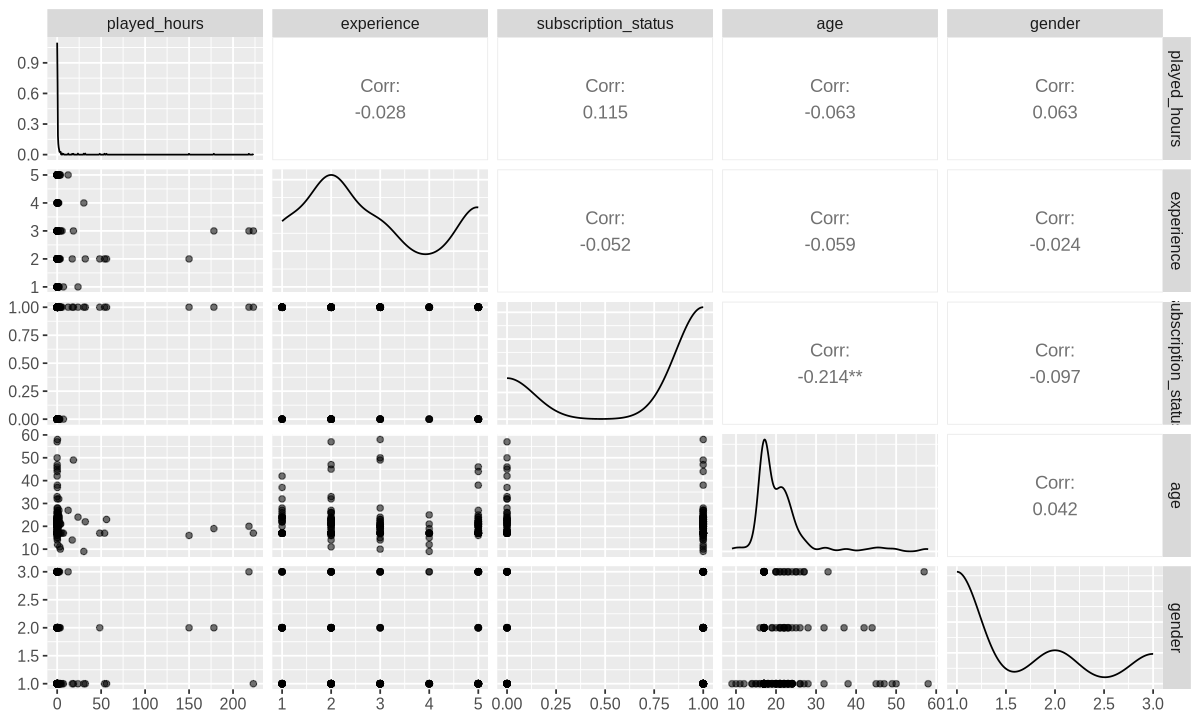

In [6]:
options(repr.plot.height = 6, repr.plot.width = 10)
# Using ggpairs, we can observe the relationships between variables to discern which ones are best to focus on.
players_num |> ggpairs(aes(alpha = 0.05)) + theme(text = element_text(size = 12)) 

###### GGpair plot observations
Despite low correlation between all variables, a closer look at the plots reveals some variables of interest regarding played_hours
1. Unsubscribed players are seemingly never likely to log a significant amount of hours played
2. Experience levels 1 and 5 (Beginners and Veterans) are also unlikely to log hours played, and 2 and 4 (Amatuers and Regulars) are most likely to log significant hours
3. Ages 30 to 60 are unlikely to log many played hours with most likely being around age 20

Based on these observations our analysis will will narrow our research question to focus on the predictors: `experience`, `subscription_status`, and `age`.

##### **PLANNED ANALYSIS**
This study employs a KNN Classification to identify unknown groupings (player types) within data of non-players. Additionally, 
Assesing similarities between non-players to identity users to avoid
Identifying which player characteristics are predictors of played_hours to identify users to target
It is evident played_hours does not share a linear relationship with the independent variables, therefore a regression of the data may not do it justice. Additionally, with over 40% of players not logging any played hours, the research team may be more interested in identifying players that contribute a significant amount of data, rather than predicting the amount of data (played_hours) they will log. 

###### TRANSFORMING PLAYED_HOURS INTO A CATEGORICAL VARIABLE
Using the interquartile rule for identifying outliers, we get rid of some values in played_hours. After that, using a histogram, we can map out the various "sections" of played hours to observe some patterns and identify common hours played.

###### CLUSTERING BASED ON PERFORMANCE
Within the amount of data contribution, analyzing similarities within each category separately can inform us of the characteristics that make up a certain group. Therefore, if each amount_played factor was to be seperately clustered, we can give names to the groupings of which we are unaware of.

#### **Clustering** <a name="knn-clasification"></a>

###### **OPTIMAL K (ELBOW PLOT)**
To determine the appropriate K value for the classification we will use the elbow plot methid

In [371]:
# Converting played_hours into a categorical variable as defined by the bounds above
players_data <- players_num |> select(subscription_status, experience, age, played_hours)

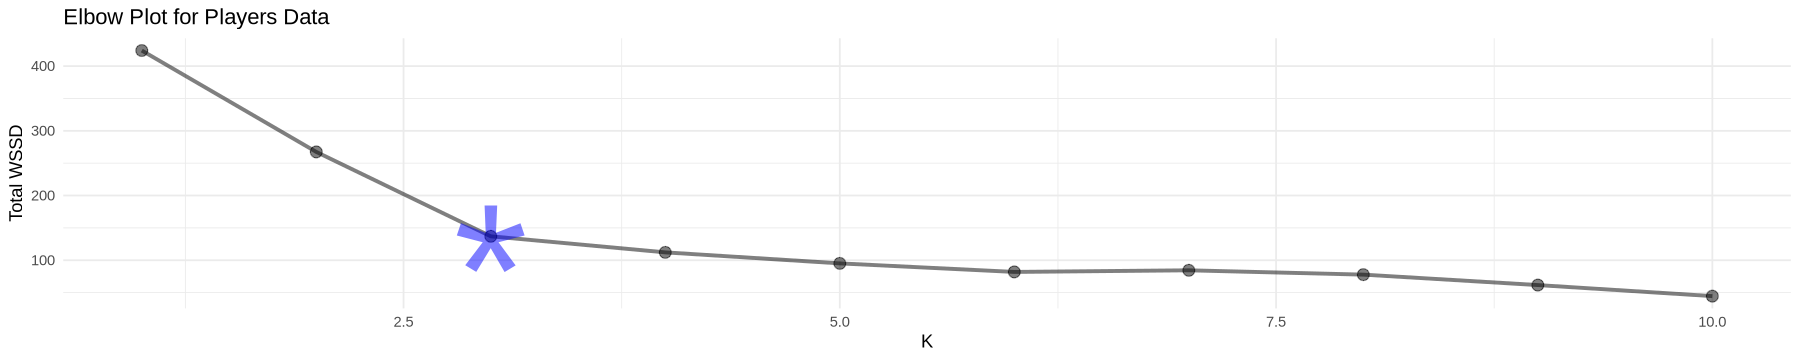

In [384]:
set.seed(2)
options(repr.plot.height = 3, repr.plot.width = 15)

kmeans_recipe <- recipe(~ subscription_status + experience + age, data = players_data) |> step_scale(experience, age) |> step_center(experience, age)

players_ks <- tibble(num_clusters = 1:10)
players_kmeans_spec_tune <- k_means(num_clusters = tune()) |> set_engine("stats")

players_tuning_stats <- workflow() |> add_recipe(kmeans_recipe) |> add_model(players_kmeans_spec_tune) |>
                        tune_cluster(resamples = apparent(players_data), grid = players_ks) |>
                        collect_metrics()

players_elbow_stats <- players_tuning_stats |> mutate(total_WSSD = mean) |> filter(.metric == "sse_within_total") |> select(num_clusters, total_WSSD)

players_elbow_plot <- players_elbow_stats |> ggplot(aes(x = num_clusters, y = total_WSSD)) + 
    geom_point(size = 3, alpha = 0.5) + geom_line(linewidth = 1.1, alpha = 0.5) + 
    annotate("text", x = 3, y = 85, label = "*", size = 40, alpha = 0.5, color = "blue") + 
    labs(x = "K", y = "Total WSSD", title = "Elbow Plot for Players Data") + theme_minimal()
players_elbow_plot

In [385]:
set.seed(2)

kmeans_spec <- k_means(num_clusters = 3) |> set_engine("stats")
kmeans_fit <- workflow() |> add_recipe(kmeans_recipe) |> add_model(kmeans_spec) |> fit(data = players_data)

clustered_data <- kmeans_fit |> augment(players_data)

clustered_data |> group_by(.pred_cluster) |> 
    summarize(count = n(), subscription_status = mean(subscription_status), 
              experience = mean(experience), age = mean(age), mean_played_hours = mean(played_hours))

.pred_cluster,count,subscription_status,experience,age,mean_played_hours
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Cluster_1,88,0.7272727,4.170455,18.86364,7.987500
Cluster_2,95,0.7684211,1.673684,20.29474,4.453684
Cluster_3,11,0.4545455,2.909091,46.63636,1.772727


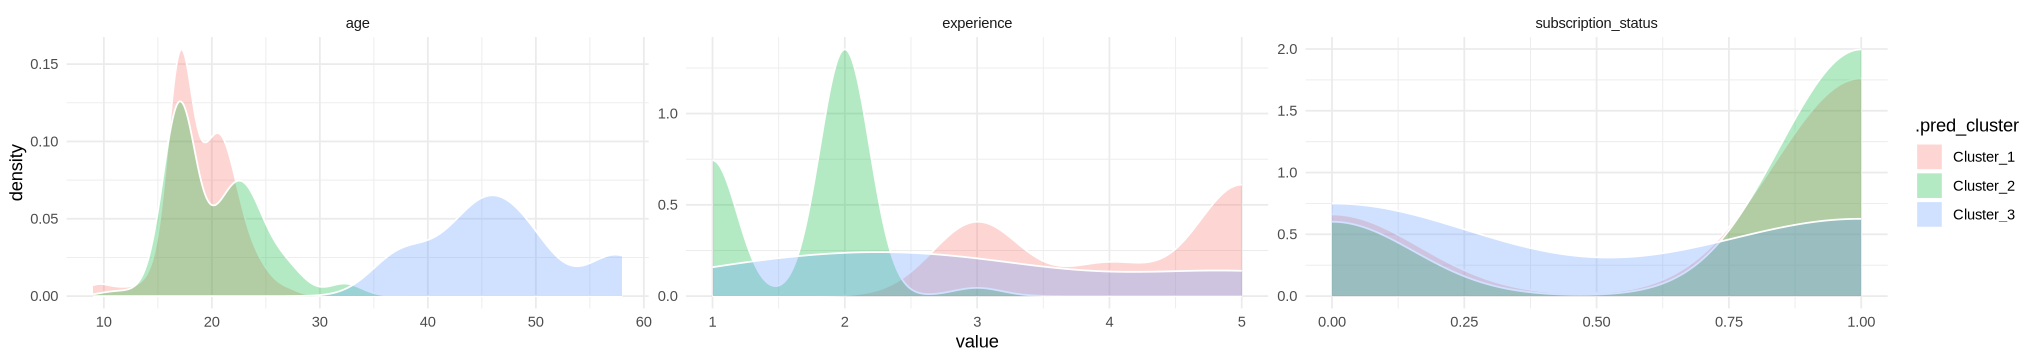

In [386]:
options(repr.plot.height = 3, repr.plot.width = 17)
clustered_data |>
    select(-played_hours)  |> 
    pivot_longer(cols = -.pred_cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .pred_cluster)) +
        geom_density(alpha = 0.3, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme(text = element_text(size = 12)) + theme_minimal()

#### **Results** <a name="results"></a>

###### **USING BOOTSTRAPPING TO MEASURE THE STABILITY OF THE CLUSTERS**
----


In [387]:
clustered_1 <- clustered_data |> filter(.pred_cluster == "Cluster_1")
clustered_2 <- clustered_data |> filter(.pred_cluster == "Cluster_2")
clustered_3 <- clustered_data |> filter(.pred_cluster == "Cluster_3")

###### **SPLITING DATA**
Spliting the data into a testing and training set

In [130]:
# removing variables not to be considered for model selection
model_selection_players <- players |> select(-hashedEmail, -name)

null_model <- lm(played_hours ~ 1, data = model_selection_players)
final_model <- lm(played_hours ~ experience + subscribe + gender + Age, data = model_selection_players)
forward_model <- step(null_model, scope = list(lower = null_model, upper = final_model), direction = "forward")

first <- lm(played_hours ~ 1, data = model_selection_players)
sec <- lm(played_hours ~ experience, data = model_selection_players)
thr <- lm(played_hours ~ experience + subscribe, data = model_selection_players)
four <- lm(played_hours ~ experience + subscribe + Age, data = model_selection_players)
fif <- lm(played_hours ~ experience + subscribe + gender + Age, data = model_selection_players)

In [168]:
or_players_data_split    <- initial_split(or_players_data, prop = 0.75, strata = amount_played)
or_players_data_training <- training(or_players_data_split)
or_players_data_testing  <- testing(or_players_data_split)

In [47]:
lm_model <- lm(played_hours ~ experience + subscribe, data = model_selection_players)
summary(lm_model)


Call:
lm(formula = played_hours ~ experience + subscribe, data = model_selection_players)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.441  -7.753  -2.628  -1.342 203.659 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)           1.491      4.776   0.312   0.7552  
experienceBeginner   -5.131      5.882  -0.872   0.3841  
experiencePro        -3.417      8.235  -0.415   0.6786  
experienceRegular    11.612      5.838   1.989   0.0481 *
experienceVeteran    -5.200      5.341  -0.974   0.3315  
subscribeTRUE         6.337      4.531   1.399   0.1636  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.87 on 190 degrees of freedom
Multiple R-squared:  0.05872,	Adjusted R-squared:  0.03395 
F-statistic:  2.37 on 5 and 190 DF,  p-value: 0.0409



Call:
lm(formula = played_hours ~ experience, data = model_selection_players)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.208  -6.017  -2.050  -0.648 204.892 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)           6.017      3.520   1.709   0.0890 .
experienceBeginner   -4.769      5.891  -0.810   0.4192  
experiencePro        -3.417      8.256  -0.414   0.6794  
experienceRegular    12.191      5.838   2.088   0.0381 *
experienceVeteran    -5.370      5.353  -1.003   0.3171  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.94 on 191 degrees of freedom
Multiple R-squared:  0.04903,	Adjusted R-squared:  0.02911 
F-statistic: 2.462 on 4 and 191 DF,  p-value: 0.04672


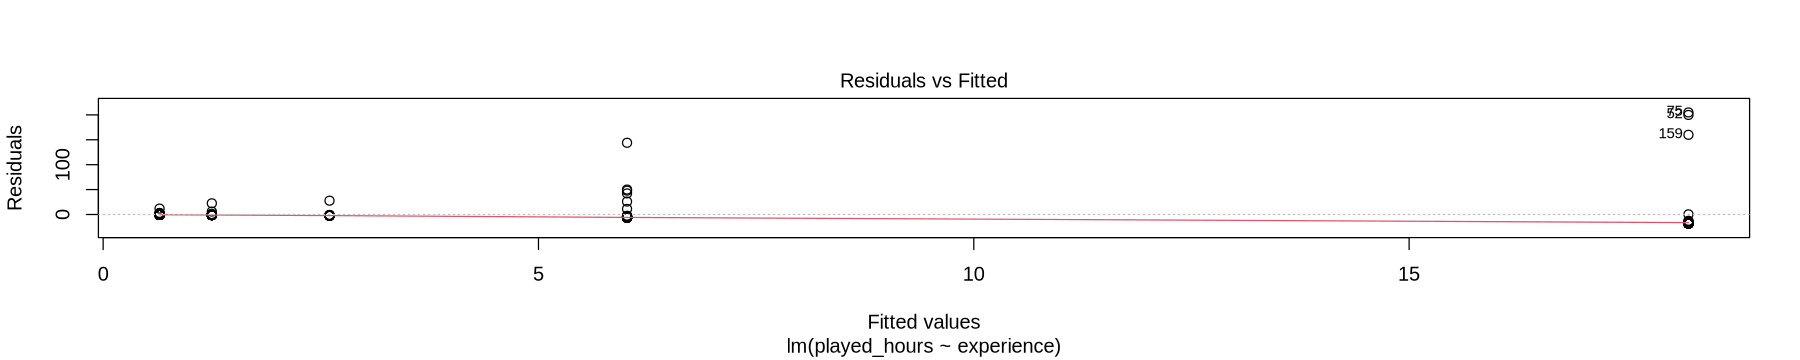

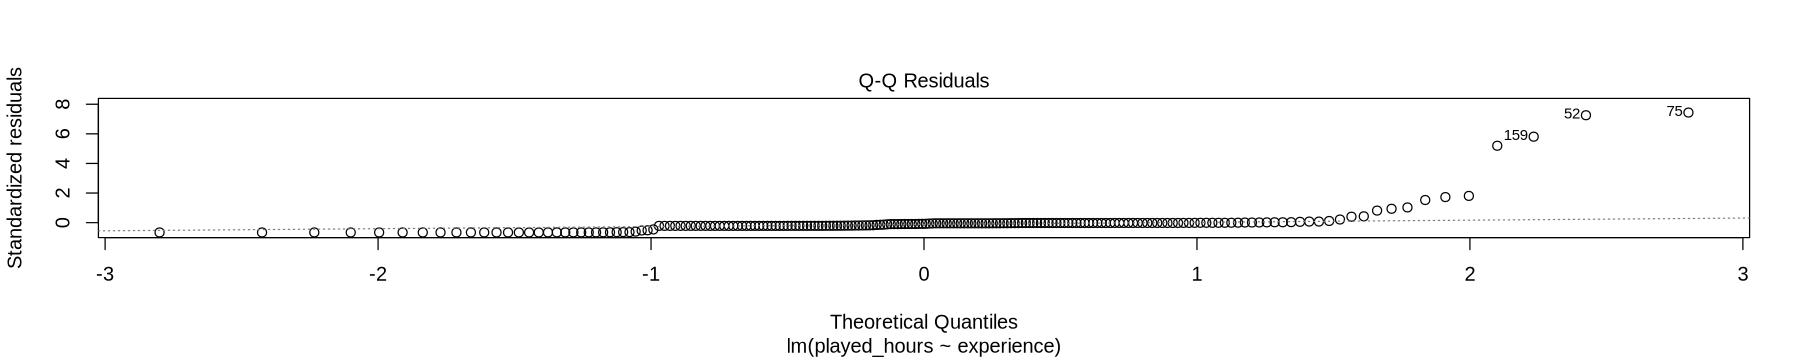

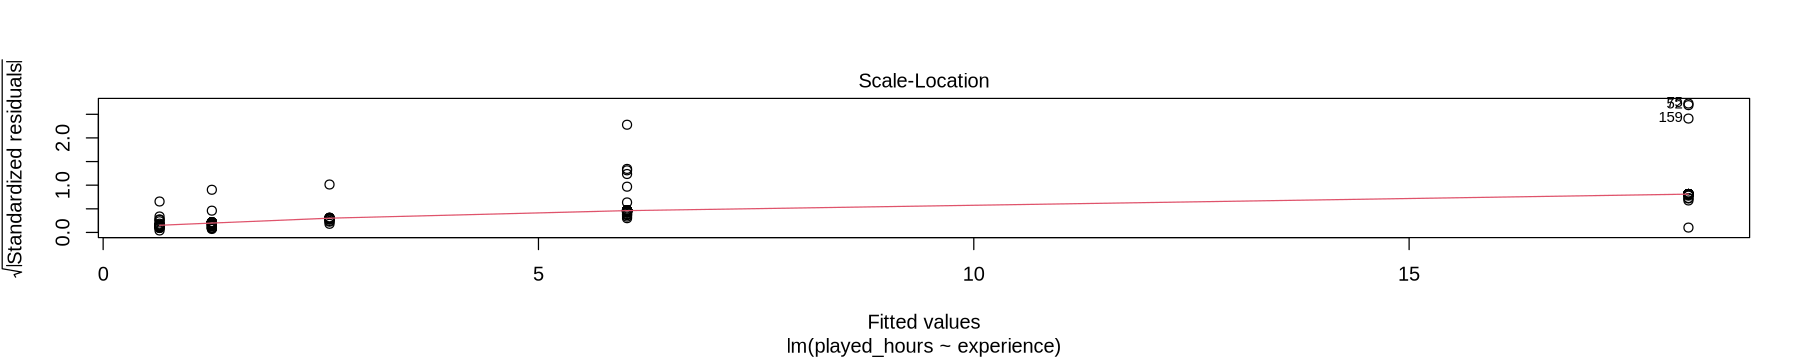

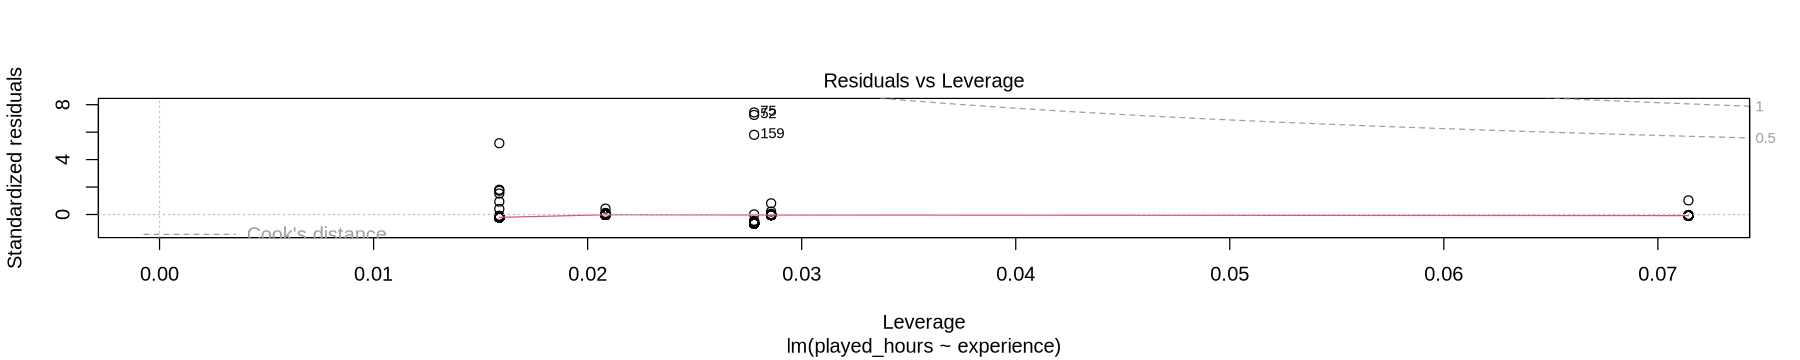

In [50]:
lm_model <- lm(played_hours ~ experience, data = model_selection_players)
summary(lm_model)
plot(lm_model)

In [104]:
resid <- residuals(lm_model)
model_selection_players$Residual <- resid
outliers_by_residual <- model_selection_players %>% filter(Residual > 100)
print(outliers_by_residual)

# A tibble: 4 × 8
  experience subscribe played_hours gender       Age resid Residuals Residual
  <chr>      <lgl>            <dbl> <chr>      <dbl> <dbl>     <dbl>    <dbl>
1 Regular    TRUE              218. Non-binary    20  200.      200.     200.
2 Regular    TRUE              223. Male          17  205.      205.     205.
3 Amateur    TRUE              150  Female        16  144.      144.     144.
4 Regular    TRUE              178. Female        19  160.      160.     160.


In [138]:
model_selection_players_no_out <- model_selection_players |> mutate(subscribe = as.numeric(subscribe, na.rm = TRUE)) 
lm_model_out <- lm(played_hours ~ experience + subscribe, data = model_selection_players_no_out)
summary(lm_model_out)


Call:
lm(formula = played_hours ~ experience + subscribe, data = model_selection_players_no_out)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.441  -7.753  -2.628  -1.342 203.659 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)           1.491      4.776   0.312   0.7552  
experienceBeginner   -5.131      5.882  -0.872   0.3841  
experiencePro        -3.417      8.235  -0.415   0.6786  
experienceRegular    11.612      5.838   1.989   0.0481 *
experienceVeteran    -5.200      5.341  -0.974   0.3315  
subscribe             6.337      4.531   1.399   0.1636  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.87 on 190 degrees of freedom
Multiple R-squared:  0.05872,	Adjusted R-squared:  0.03395 
F-statistic:  2.37 on 5 and 190 DF,  p-value: 0.0409


_describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
loads data 
wrangles and cleans the data to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all figures should have a figure number and a legend_

###### CLUSTERING NON PLAYERS
---

###### WRANGLING
---

###### RESEARCH QUESTION

#### Discussion <a name="discussion"></a>  

#### References <a name="references"></a>
[1]  Smith, A. (2025, January 21). Plaicraft.ai launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/  
[2]  James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning. 1st ed. Springer. https://www.statlearning.com/. 